# Sales with uncertainty

Using data from [Kaggle, for Rossman stores](https://www.kaggle.com/c/rossmann-store-sales/data).

Our goal in this exercise is to estimate the average sales as a function of the day of the week, with uncertainty analysis derived in two ways - analytically and via random realisation. This example isn't meant to be what you'd want to do in this scenario to answer a simple question, but good practise on how to simulate RV to estimate uncertainty, the loss of information that comes with if you do analytic approximations, but why they can be useful.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm
df = pd.read_csv("data\sales.csv")
df.info()

C:\Users\rahat\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [2]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [3]:
df2 = df.loc[(df.Open == 1), ["Store", "DayOfWeek", "Sales", "Customers"]]

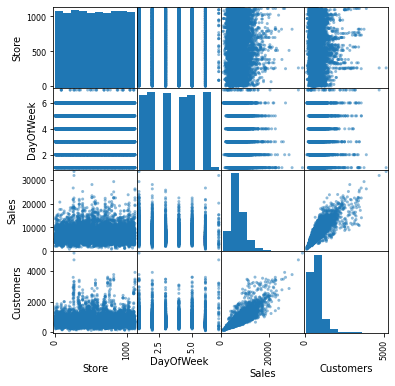

In [4]:
pd.plotting.scatter_matrix(df2.iloc[::100, :], figsize=(6, 6));

Here is a very short way of doing things. Aggregate and return with a Gaussian assumption.

In [5]:
df3 = df2.groupby("DayOfWeek").agg({"Sales": ["mean", "std"]})
df3

Sales             
                  mean          std
DayOfWeek                          
1          8216.073074  3691.768876
2          7088.113656  3066.237110
3          6728.122978  2781.775174
4          6767.310159  2764.548119
5          7072.677012  2764.915744
6          5874.840238  2852.730426
7          8224.723908  6235.152960

But this is not that educational. Let's instead plot a distribution, one per day of week, for the average sale from any given customer (over all stores).

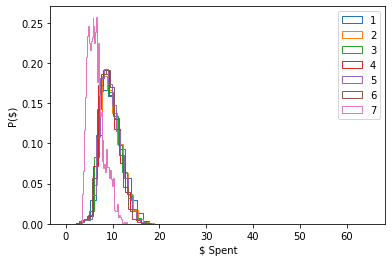

In [6]:
for day, frame in df2.groupby("DayOfWeek"):
    plt.hist(frame.Sales / frame.Customers, bins=50, label=day, histtype='step', density=True)
plt.legend()
plt.xlabel("$ Spent")
plt.ylabel("P($)");

Looks like a good fit to a normal to me! (Don't look at Sunday, it hurts). Lets have a look at the relationship between means and standard deviations over each day.

{1: {'spend': (9.896977492736108, 2.384816430535843)}, 2: {'spend': (9.59442207315989, 2.263603542447267)}, 3: {'spend': (9.496812149001853, 2.199600748654486)}, 4: {'spend': (9.358152366945113, 2.1203189159680598)}, 5: {'spend': (9.438294893592747, 2.1183778390610475)}, 6: {'spend': (9.260104343618403, 1.9802523286171794)}, 7: {'spend': (6.458912595386233, 1.7326550392889775)}}


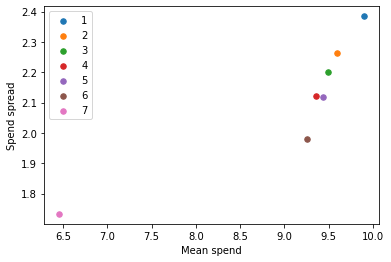

In [7]:
res = {}
for day, frame in df2.groupby("DayOfWeek"):
    data = frame.Sales / frame.Customers
    mean, std = data.mean(), data.std()
    res[day] = {"spend": (mean, std)}
    plt.scatter([mean], [std], label=day, s=30)
plt.legend();
plt.xlabel("Mean spend")
plt.ylabel("Spend spread")
print(res)

Whoa, what is happening on Sunday? Not a profitable day at all! The almost linear relationship we see on the right would be consistent with the variance scaling as a function of spend. Ie if we normalise the spread in terms of the spend it might flatten out. Just as an interesting side, we don't actually need to use that insight into the data, but we have it just in case!

For example, if we were to use this data insight, we would only need the number of customers and mean spend (two data vectors) instead of number of customers, mean spend and spend spread. Because we can utilise the existing relationships to predict that. But given our data has spread, we might as well use that!

Now, we have our normal approximation to spend per customer. We now need to quantify the number of customers as a function of day. Lets visualise again.

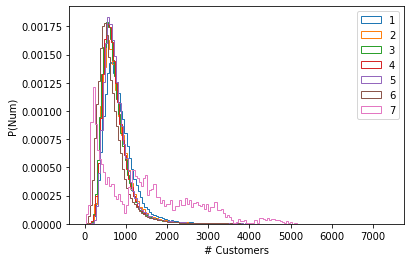

In [8]:
for day, frame in df2.groupby("DayOfWeek"):
    plt.hist(frame.Customers, bins=100, histtype="step", label=day, density=True)
plt.legend();
plt.xlabel("# Customers")
plt.ylabel("P(Num)");

Dammit Sunday, stop ruining anything. At this point, I'd be investigating Sunday more if I had but the data. Opening hour differences? Discounts on Sunday? Only some stores open on a Sunday in more populated areas or areas in higher socio-economic areas? We'd want to find supplementary data to delve into this, which you can easily do if you're working in a company setting but you can't do if you're using old open-sourced data.

Now, number of customers, positive only number, counting real values... sounds like a good application for a log normal to me!

1 (0.42038878818699443, -10.032692993969142, 788.8147308767948)
2 (0.42200435444496087, -8.635117127779155, 708.0591923600157)
3 (0.4058240663771445, -14.951182400678398, 691.153794854348)
4 (0.3996014591216416, -18.88871077202447, 710.0978077100474)
5 (0.3856014095983238, -9.0011023377721, 728.4210866652444)
6 (0.48161329385838514, -10.237149440491677, 593.1012008082414)
7 (0.8966735024097416, -47.63982355166327, 1057.8329147904133)


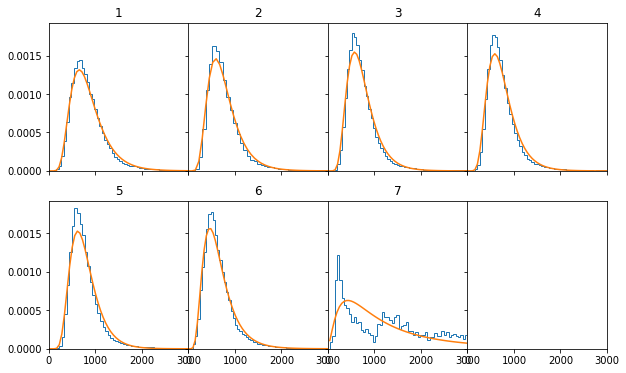

In [9]:
fig, axes = plt.subplots(figsize=(10,6), nrows=2, ncols=4, sharey=True, sharex=True)
fig.subplots_adjust(wspace=0)

for ax, (day, frame) in zip(axes.flatten(), df2.groupby("DayOfWeek")):
    params = lognorm.fit(frame.Customers, scale=1000)
    ax.hist(frame.Customers, bins=100, density=True, histtype="step")
    xs = np.linspace(frame.Customers.min(), frame.Customers.max(), 100)
    ax.plot(xs, lognorm.pdf(xs, *params))
    ax.set_title(day)
    ax.set_xlim(0, 3000)
    res[day]["cust"] = list(params)
    print(day, params)

So with the exception of Sunday, we could really model *all* of these dists as having 0 mean, shape parameter of around 0.4, and a scale that varies slightly with each day, generally around 700.

Again, this is in the vein of finding the information thats important in the data. If we did discard Sunday and used the previous data insight, we can now say that daily profits can be predicted now using only two numbers - the scale of the lognorm representing the number of customers, and the mean value of each customer spending. We would infer every other value.

Lets compare that reduced number inference, to a full inference, to just the average we started with.

In [10]:
df2.groupby("DayOfWeek").agg({"Sales": ["mean", "std"], "Customers": ["mean", "std"]}).head()

Sales                Customers            
                  mean          std        mean         std
DayOfWeek                                                  
1          8216.073074  3691.768876  855.444984  420.044289
2          7088.113656  3066.237110  769.986753  389.827138
3          6728.122978  2781.775174  740.598876  372.526903
4          6767.310159  2764.548119  755.569784  379.039732
5          7072.677012  2764.915744  781.771639  383.004679

In [11]:
# If we wanted to draw simulated values and run with that (instead of using the actual data)
percentiles = 100 * norm.cdf([-1, 0, 1])
n = 100000
# for each day, sample # customers and sample their spend
for day, dic in res.items():
    spend = norm(*dic["spend"]).rvs(n)
    custs = lognorm(*dic["cust"]).rvs(n)
    profit = custs * spend
    vals = np.percentile(profit, percentiles)
    diff = np.diff(vals)
    print(f"Day {day} has profit {vals[1]:.2f}(+{diff[1]:.2f})(-{diff[0]:.2f})")

Day 1 has profit 7524.86(+4744.58)(-2979.43)
Day 2 has profit 6547.90(+4118.01)(-2584.14)
Day 3 has profit 6280.72(+3797.66)(-2443.71)
Day 4 has profit 6349.92(+3771.45)(-2439.31)
Day 5 has profit 6654.94(+3762.64)(-2480.01)
Day 6 has profit 5282.41(+3693.03)(-2237.25)
Day 7 has profit 6242.02(+10205.70)(-3968.96)


Note that these estimates are lower! Using this method is less sensitive to outliers pulling the profit up, and we've obviously lost some information in our approximations.

Lets now consider the case we compress down the data to just two numbers - mean number of customers and average spend.

In [12]:
for day, dic in res.items():
    mean_spend = dic["spend"][0]
    num_cust = dic["cust"][2]
    
    spend = norm(mean_spend, mean_spend*0.25).rvs(n)
    custs = lognorm(0.4, 0, num_cust).rvs(n)
    profit = custs * spend
    vals = np.percentile(profit, percentiles)
    diff = np.diff(vals)
    print(f"Day {day} has profit {vals[1]:.2f}(+{diff[1]:.2f})(-{diff[0]:.2f})")

Day 1 has profit 7620.10(+4573.23)(-2962.21)
Day 2 has profit 6618.26(+4006.74)(-2571.15)
Day 3 has profit 6418.81(+3809.93)(-2492.65)
Day 4 has profit 6497.98(+3915.41)(-2518.23)
Day 5 has profit 6724.62(+4017.20)(-2605.65)
Day 6 has profit 5369.86(+3216.30)(-2078.57)
Day 7 has profit 6675.71(+3998.26)(-2592.47)


So you can see, apart from Sunday, this is a pretty good approximation. And if you do something like this you can try and answer further questions easily. Imagine you now get information that in the week before holidays the amount people spend scatters more. For example, there is a 50% increase in scatter in the spend and people also spend on average a dollar more. How would that impact profit? 

Using the original way, its not obvious how we'd write down a one line estimate. But its easy with our approximations - just modify the distributions we're drawing from.

In [13]:
for day, dic in res.items():
    mean_spend = dic["spend"][0]
    num_cust = dic["cust"][2]
    
    spend = norm(mean_spend+1, mean_spend*0.25*1.5).rvs(n)
    custs = lognorm(0.4, 0, num_cust).rvs(n)
    profit = custs * spend
    vals = np.percentile(profit, percentiles)
    diff = np.diff(vals)
    print(f"Day {day} has profit {vals[1]:.2f}(+{diff[1]:.2f})(-{diff[0]:.2f})")

Day 1 has profit 8309.51(+5587.57)(-3626.83)
Day 2 has profit 7264.22(+4879.75)(-3178.83)
Day 3 has profit 7006.16(+4702.03)(-3041.82)
Day 4 has profit 7115.44(+4776.17)(-3087.22)
Day 5 has profit 7338.01(+4951.93)(-3186.20)
Day 6 has profit 5884.65(+3936.96)(-2567.16)
Day 7 has profit 7662.63(+5029.02)(-3271.46)


Note that in this example there is no real reason we'd go to all this effrot to characterise our distributions only to sample from them again. We'd just use the real data - we have enough samples to do so. Or sample from the empirical PDF if we *really* wanted to sample. This exercise is simply meant to show you how you *can* use random number sampling to estimate uncertainty. It also means that we can answer more flexible questions - the one line original method only caters for scenarios exactly as the data describes.